# Краткое описание:

Проверка нескольких гипотез на основе полученных данных из сервиса по аренде самокатов.\
Какие пользователи более "выгодны" компании?\
Как влияет подписка на ползование сервисом?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom

## Шаг 1. Загрузка данных

In [2]:
users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', parse_dates=['date'])
subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
print(users_go.head(10))

print(rides_go.head(10))

print(subscriptions_go.head(10))

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra
5        6      Регина   25       Краснодар             ultra
6        7       Игорь   23            Омск             ultra
7        8        Юрий   23       Краснодар             ultra
8        9          Ян   21       Пятигорск             ultra
9       10     Валерий   18    Екатеринбург             ultra
   user_id     distance   duration       date
0        1  4409.919140  25.599769 2021-01-01
1        1  2617.592153  15.816871 2021-01-18
2        1   754.159807   6.232113 2021-04-20
3        1  2694.783254  18.511000 2021-08-11
4        1  4028.687306  26.265803 2021-08-28
5        1  2770.890808  16.650138 2021-10

# Вывод:
1. У нас есть три таблицы с различнимы данными о пользователях.\
2. Есть два типа подписки у пользователей free и ultra.\
3. В будующем можно объеденить 2 таблицы по индексу пользователей, а затем объеденить все в один датафрейм по виду подписки.\
4. Можно округлить значения в колонке duration.
5. Цена за минуту поездки разная для разных типов подписки(8 для free и 6 для ultra), так же старт поездки бесплатен для пользователей с подпиской, а пользователи без подписки платят 50р за каждый старт.

## Шаг 2. Предобработка данных

In [3]:
rides_go['month'] = rides_go['date'].dt.month

In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [6]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [7]:
print(users_go.duplicated().sum())
print(rides_go.duplicated().sum())
print(subscriptions_go.duplicated().sum())

31
0
0


In [8]:
users_go = users_go.drop_duplicates()

In [9]:
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [10]:
users_go['city'] = users_go['city'].replace('Ростов-на-Дону','Ростов_на_Дону',regex=True)

In [11]:
print(users_go.isna().sum())

print(rides_go.isna().sum())

print(subscriptions_go.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


# Вывод по разделу:
1. Изменил формат даты, на datetime64.
2. Добавил столбец с номером месяца.
3. Убрал дупликаты из дата фрейма users_go
4. Переминовал город Ростов на Дону к змеиному регистру.
5. Пустых значений не обнаруженно.
 

## Шаг 3. Исследовательский анализ данных

In [12]:
users_go.sort_values('city')

,user_id,name,age,city,subscription_type
766,767,Ксения,28,Екатеринбург,free
896,897,Алиса,27,Екатеринбург,free
195,196,Татьяна,35,Екатеринбург,ultra
890,891,Захар,19,Екатеринбург,free
887,888,Эмиль,34,Екатеринбург,free
...,...,...,...,...,...
505,506,Вероника,26,Тюмень,ultra
1181,1182,Одиссей,26,Тюмень,free
507,508,Станислав,15,Тюмень,ultra
1098,1099,Назар,23,Тюмень,free


In [13]:
users_sort_by_city = (users_go
                      .pivot_table(index='city', values='user_id', aggfunc='count')
                      .sort_values('user_id', ascending=False).reset_index()
                     )

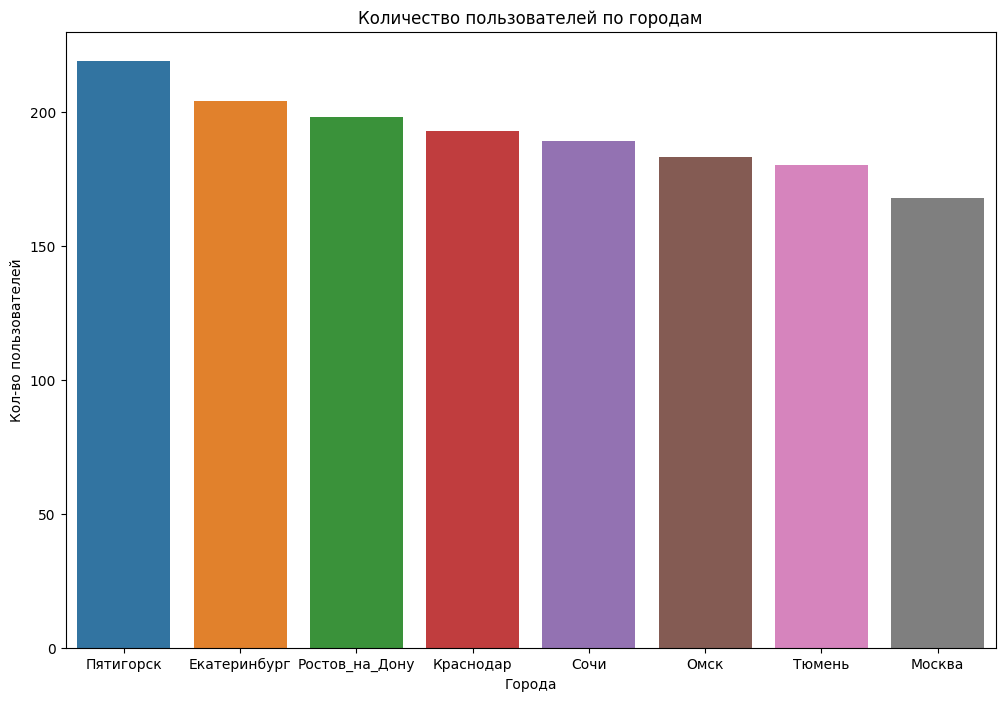

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=users_sort_by_city['city'], y=users_sort_by_city['user_id'], data=users_sort_by_city);
plt.title('Количество пользователей по городам')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Города')
plt.show()

Самое большое кол-во пользователей в Пятигорске, самое малое в Москве

In [15]:
users_sort_by_subs = (users_go
                      .pivot_table(index='subscription_type',values='user_id',aggfunc='count')
                      .sort_values('user_id', ascending=False)
                      .reset_index()
                     )

In [16]:
print(users_sort_by_subs)

  subscription_type  user_id
0              free      835
1             ultra      699


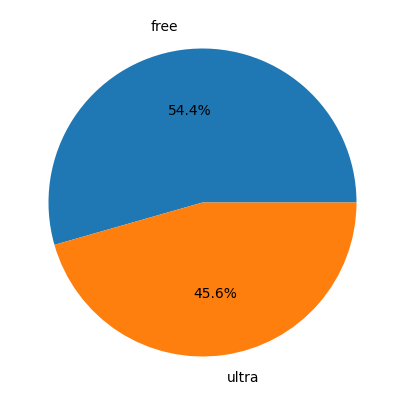

In [17]:
plt.rcParams["figure.figsize"] = (20,5)
plt.pie(users_sort_by_subs['user_id'],labels=users_sort_by_subs['subscription_type'],labeldistance=1.15, autopct='%1.1f%%' );

По графику видно, что большинство пользователей(54,4%) пользуются сервисом без подписки.

In [18]:
users_sort_by_age = (users_go
                     .pivot_table(index='age',values='user_id',aggfunc='count')
                     .sort_values('user_id', ascending=False)
                     .reset_index()
                     )

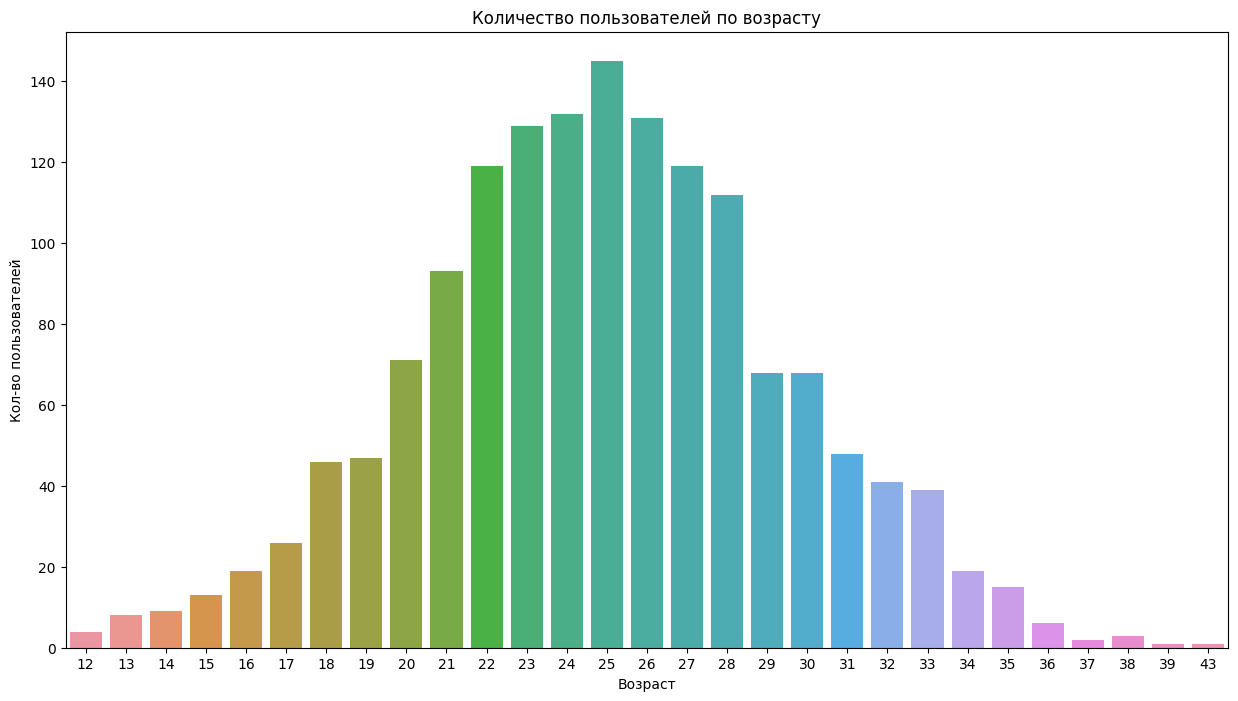

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=users_sort_by_age['age'], y=users_sort_by_age['user_id'], data=users_sort_by_age);
plt.title('Количество пользователей по возрасту')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Возраст')
plt.show()

In [20]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

По анализу видно:
1. Большинство пользователей в возрасте от 15 до 35 лет.
2. Средний возраст 25 лет

In [21]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

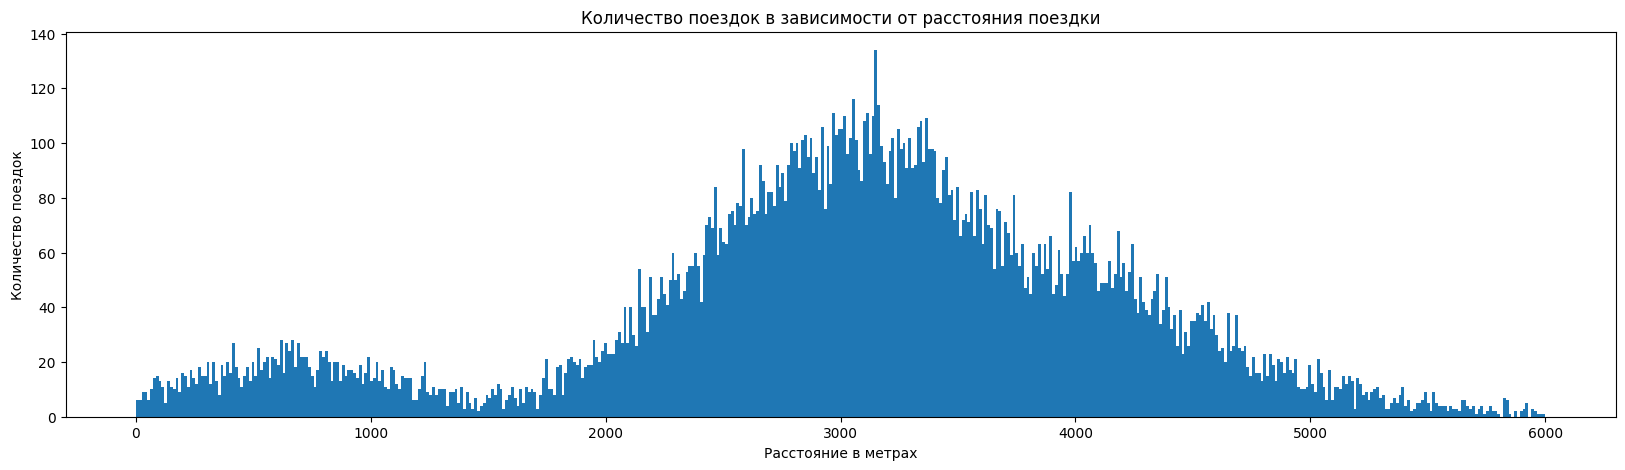

In [22]:
plt.hist(rides_go['distance'], bins=500, range=(1,6000))
plt.title('Количество поездок в зависимости от расстояния поездки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

По анализу видно: 
1. Cредняя поездка 3400 м.
2. Есть более малый пик в районе 700-800 м, что означает достаточно частые поездки на расстояния до километра.                    

In [23]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

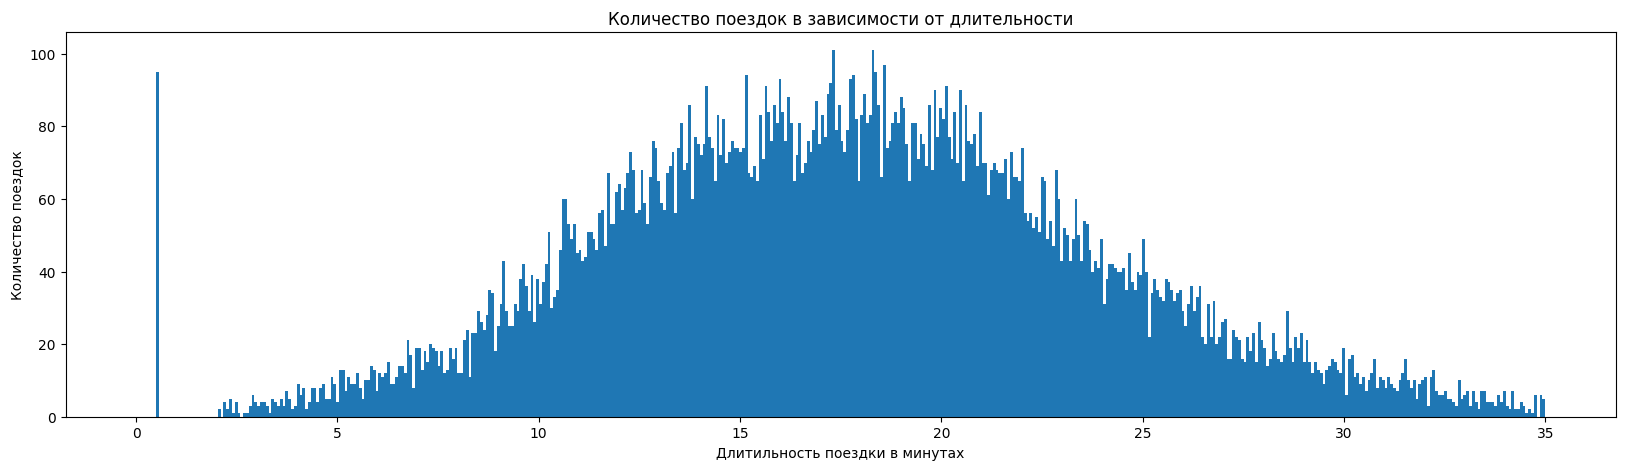

In [24]:
plt.hist(rides_go['duration'], bins=500, range=(0,35))
plt.title('Количество поездок в зависимости от длительности')
plt.xlabel('Длитильность поездки в минутах')
plt.ylabel('Количество поездок')
plt.show()

По анализу видно:
1. Среднее время в пути 17 минут.
2. Так же видим большой пик в районе 1 минуты, причем кол-во таких поездок достаточно большое, возмможно люди не могут начать аренду, либо, они отменяют поездку и пользуются другими сервисами.

# Вывод по разделу:
1. Самое большое кол-во пользователей в Пятигорске, самое малое в Москве
2. Большинство пользователей в возрасте от 15 до 35 лет, cредний возраст 25 лет 
3. Cредняя поездка 3400 м, так же есть пик около 750 м, который означает популярность коротких поездок
4. Большинство пользователей(54,4%) пользуются сервисом без подписки.
5. Среднее время в пути 17 минут.

## Шаг 4. Объединение данных

In [25]:
df_group = pd.merge(users_go, subscriptions_go, on='subscription_type', how='left')
df_group = pd.merge(df_group, rides_go, on='user_id',how='left' )

In [26]:
df_group_free = df_group[df_group['subscription_type'] == 'free']
df_group_ultra = df_group[df_group['subscription_type'] == 'ultra']

In [27]:
print(df_group_free.head(10))
print(df_group_ultra.head(10))

      user_id   name  age  city subscription_type  minute_price  \
6500      700  Айдар   22  Омск              free             8   
6501      700  Айдар   22  Омск              free             8   
6502      700  Айдар   22  Омск              free             8   
6503      700  Айдар   22  Омск              free             8   
6504      700  Айдар   22  Омск              free             8   
6505      700  Айдар   22  Омск              free             8   
6506      700  Айдар   22  Омск              free             8   
6507      700  Айдар   22  Омск              free             8   
6508      700  Айдар   22  Омск              free             8   
6509      700  Айдар   22  Омск              free             8   

      start_ride_price  subscription_fee     distance   duration       date  \
6500                50                 0  2515.690719  14.944286 2021-01-02   
6501                50                 0   846.932642  16.234663 2021-02-01   
6502                50   

In [28]:
print(df_group_free['distance'].describe())
print(df_group_free['duration'].describe())

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64
count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


In [29]:
print(df_group_ultra['distance'].describe())
print(df_group_ultra['duration'].describe())

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64
count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


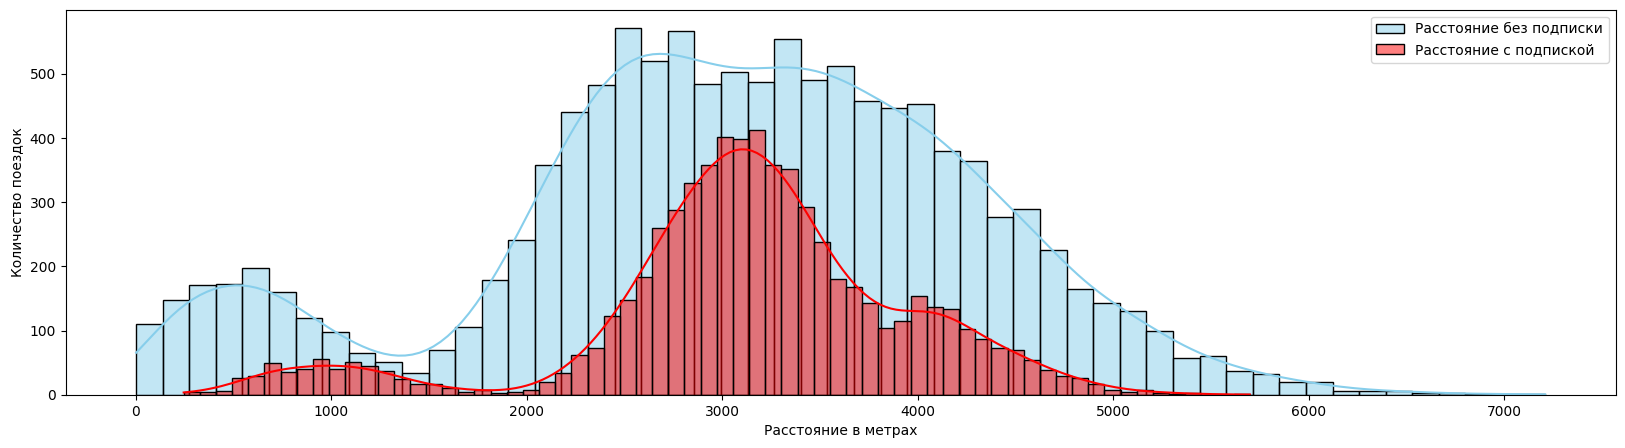

In [30]:
sns.histplot(data=df_group_free, x='distance', color="skyblue", label='Расстояние без подписки', kde=True)
sns.histplot(data=df_group_ultra, x='distance', color="red", label='Расстояние с подпиской', kde=True)
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние в метрах')
plt.legend() 
plt.show()

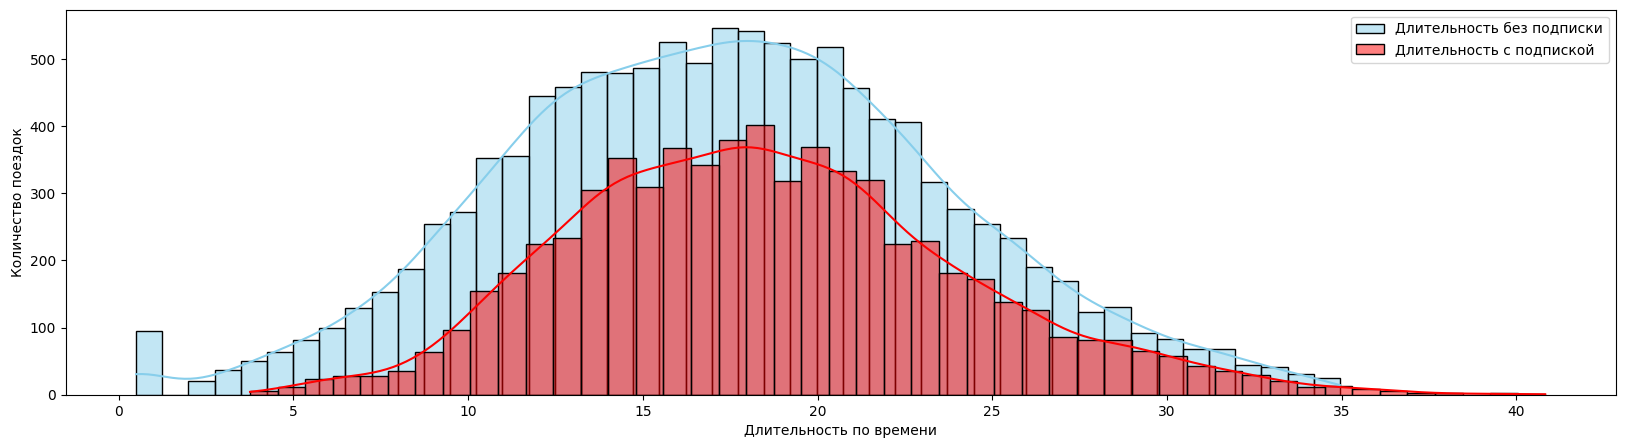

In [31]:
sns.histplot(data=df_group_free, x='duration', color="skyblue", label='Длительность без подписки', kde=True)
sns.histplot(data=df_group_ultra, x='duration', color="red", label='Длительность с подпиской', kde=True)
plt.ylabel('Количество поездок')
plt.xlabel('Длительность по времени')
plt.legend() 
plt.show()

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b>
<br>Ты правильно делаешь, что совмещаешь оба графика, так их проще сравнить друг с другом
</div>

По графикам видно, что ползователей без подписки в сервисе больше, так же они чаще пользуются сервисом для поездок меньше минуты.\
На второй гистограмме видно, что пользователи с подпиской не берут аренду меньше чем на 4 минуты.\
Среднее расстояние которое проезжают пользователи без подписки ниже (3045.495282), чем среднее расстояние которое проезжают пользователи с подпиской (3115.445388).\
Среднее время аренды, у людей с подпиской больше (18.541985), чем среднее время у людей без подписки (17.390909).

# Вывод по разделу: 
1. Объеденил дата фреймы с данными о пользователях, поездках и подписках в один датафрейм.
2. Создал два дата фрема с пользователями с подпиской, и с пользователями без.
3. построил гистограммы показывающие различия в поведении пользователей при аренде.


## Шаг 5. Подсчёт выручки

In [32]:
df_group['duration'] = np.ceil(df_group['duration'])

In [33]:
df_group_ag = df_group.pivot_table(index=('user_id','month'),
                                    values=('distance','duration','minute_price','start_ride_price','subscription_fee'),
                                    aggfunc=({'distance': {'count','sum'},
                                             'duration': 'sum',
                                             'minute_price' : min,
                                             'start_ride_price': min,
                                             'subscription_fee': min})
)

In [34]:
df_group_ag.columns = ['count','distance_sum', 'duration_sum','minute_price','start_ride_price','subscription_fee']

In [35]:
df_group_ag['income'] =(df_group_ag['start_ride_price']*df_group_ag['count']+
                        df_group_ag['duration_sum']*df_group_ag['minute_price']+
                        df_group_ag['subscription_fee']
                       )

In [36]:
df_group_ag.head(10)

count  distance_sum  duration_sum  minute_price  \
user_id month                                                    
1       1          2   7027.511294          42.0             6   
        4          1    754.159807           7.0             6   
        8          2   6723.470560          46.0             6   
        10         2   5809.911100          32.0             6   
        11         3   7003.499363          56.0             6   
        12         2   6751.629942          28.0             6   
2       3          3  10187.723006          63.0             6   
        4          2   6164.381824          40.0             6   
        6          1   3255.338202          14.0             6   
        7          2   6780.722964          48.0             6   

               start_ride_price  subscription_fee  income  
user_id month                                              
1       1                     0               199   451.0  
        4                     0               199   241.0  
        8                     0               199   475.0  
        10                    0               199   391.0  
        11                    0               199   535.0  
        12                    0               199   367.0  
2       3                     0               199   577.0  
        4                     0               199   439.0  
        6                     0               199   283.0  
        7                     0               199   487.0

## Шаг 6. Проверка гипотез

### Проверим гипотезу, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

H0 - пользователи с подпиской тратят столько же времени как и пользователи без подписки.\
H1 - Пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки.

In [37]:
result = st.ttest_ind(df_group_ultra['duration'], df_group_free['duration'], alternative='greater')

alpha = 0.05

print(result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем ')
else:
    print('Не получилось отвергнуть нулевую гипотезу')




1.2804098316645613e-34
Отвергаем 


По результатам t-теста, можно сказать, что пользователи с подпиской тратят больше времени, на поездки, нежели пользователи без подписки.

### Проверим гипотезу, что среднее расстояние которое проезжают пользователи с подпиской не превышает 3130 метров

H0 - пользователи с подпиской проезжают 3130 метро.\
H1 - Пользователи с подпиской проезжают больше 3130 метро.

In [38]:

distanse = 3130

result = st.ttest_1samp(df_group_ultra['distance'], distanse, alternative='greater')

alpha = 0.05

print('Среднее значение выборки', df_group_ultra['distance'].mean())
print(result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


Среднее значение выборки 3115.4453880370247
0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


По результатам t-теста, можно сказать, что среднее расстояние которое проезжают пользователи с подпиской не превышает 3130 метров, нулевую гипотезу отвергнуть не получилось.

### Проверим гипотезу, что помесячная выручка от пользователей с подпиской, выше чем у пользователей без подписки.

H0 - пользователи с подпиской приносят такую же прибыль.
H1 - Пользователи с подпиской приносят большую прибыль.

In [39]:
x1 = df_group_ag.loc[df_group_ag['subscription_fee'] != 0, 'income'] # пользователи с подпиской
х2 = df_group_ag.loc[df_group_ag['subscription_fee'] == 0, 'income'] # пользователи без подписки

result = st.ttest_ind(x1,х2, alternative='greater')

alpha = 0.05

print(result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем H0')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем H0


По результатам t-теста, можно сказать, что пользователи с подпиской приносят больше прибыли, чем пользователи без подписки.

### Для проведения потребуется двухвыборочный t-тест для зависимых выборок
scipu.stats.ttest_rel(...)

# Вывод по разделу:

Результатам исследования можно сделать следующие выводы:\
1.Пользователи с подпиской тратят больше времени на поездки, и приносят больше прибыли компании.\
2.Средняя поездка пользователей, не превышает 3130 метров, что оптимально с точки зрения износа самоката.\

## Шаг 7. Распределения

### 

In [40]:
n = 0 # Не известная величина, сколько промокодов раздать.
p = 0.1 # Вероятность с которой продлевают подписку.
k = 100 # Кол-во требуемых успехов
binom1 = 0.05 # Вероятность не выполнить план.

while binom.cdf(k,n,p) > binom1:
        n = n+1

print('При n =',n,', вероятность не выполнить план менее', ((binom.cdf(k,n,p)*100).round(2)), '%')

При n = 1172 , вероятность не выполнить план менее 4.95 %


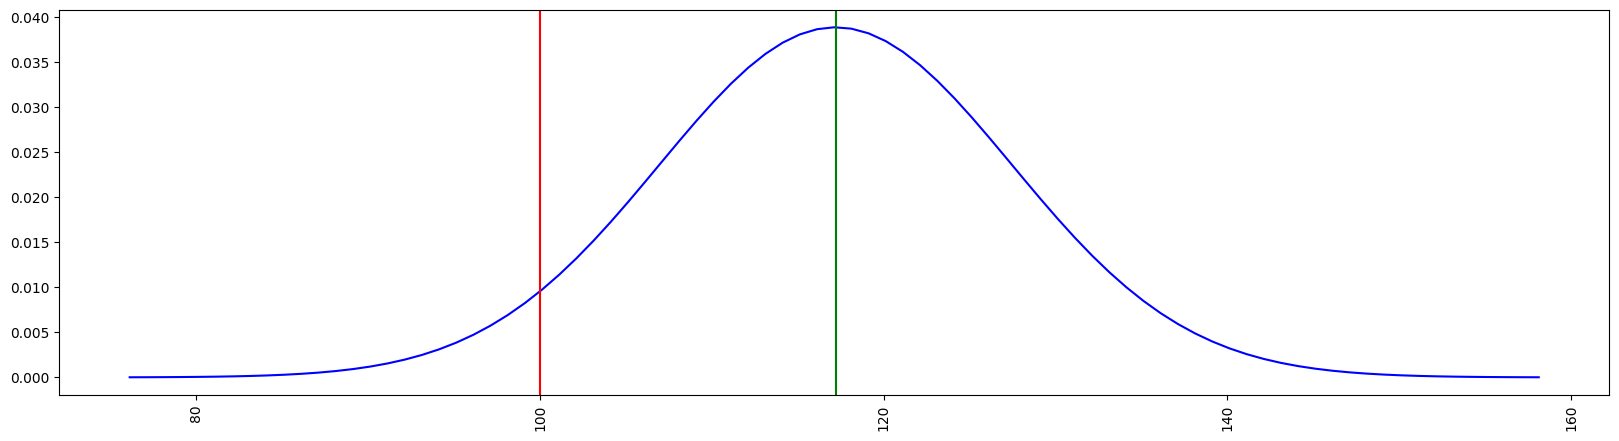

In [41]:
mu = n * p
sigma = (n * p * (1 - p))**0.5

distr = st.norm(mu, sigma)

arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)

plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.xticks(rotation=90)
plt.axvline(x=k, color='red')
plt.axvline(x=mu, color='green')
plt.show()

# Вывод.
Если разослать 1172 промокода, вероятность не выполнить план будет меньше 5%.

In [42]:
n=1000000 # Кол-во писем
p=0.4 # Вероятность открытия
k=399500 #

binom.cdf(k,n,p)

0.1539584359564276

Вероятность открытия сообщений: 0.15371708296369768


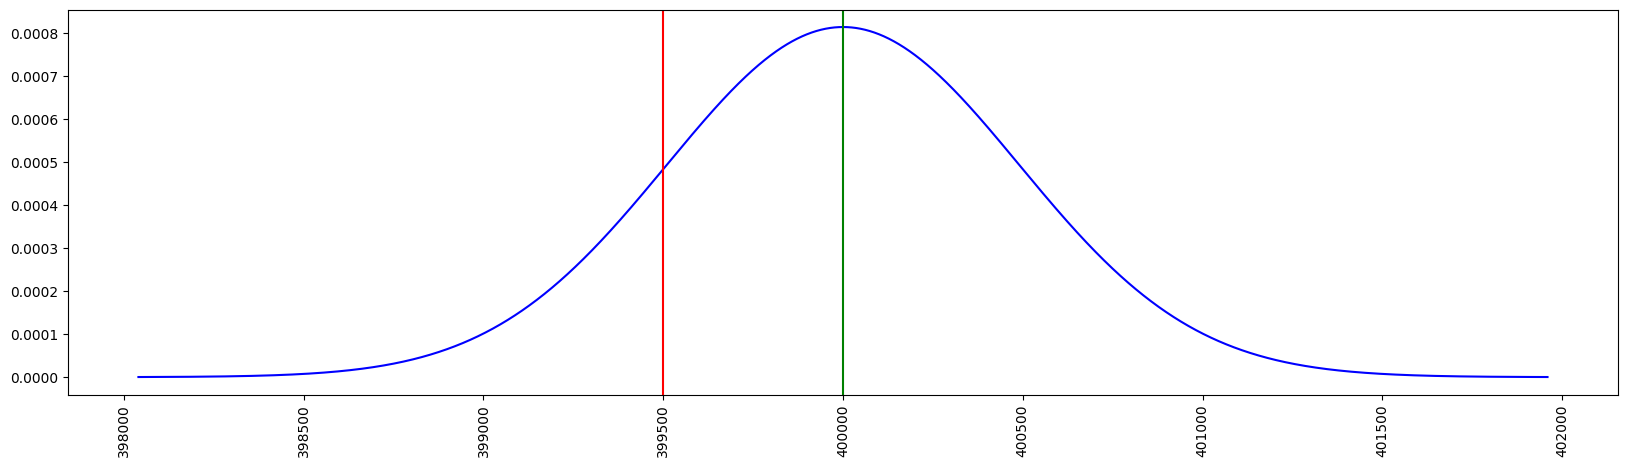

In [43]:
n = 1000000
p = 0.4
k = 399500

mu = n * p
sigma = (n * p * (1 - p))**0.5

distr = st.norm(mu, sigma) 

result = distr.cdf(k)
print('Вероятность открытия сообщений:', result)

arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.xticks(rotation=90)
plt.axvline(x=k, color='red')
plt.axvline(x=mu, color='green')
plt.show()

# Вывод.
Если разослать 1 млн. писем, вероятность того, что откроют не более 399500 составляет 15.3%.

# Общий вывод по работе.
1.Пустых данных в таблицах не обнаруженно.\
2. Дупликаты были убраны из первой таблицы.

Результаты исследовательского анализа:
1. Самое большое кол-во пользователей в Пятигорске, самое малое в Москве
2. Большинство пользователей(54,4%) пользуются сервисом без подписки.
3. Средний возраст пользователей 25 лет.
4. Cредняя поездка 3400 м, а среднее время в пути 17 минут.
5. Объеденил данный в один дата фрейм, а затем разделил его на 2 для пользователей с подпиской и без.
5. Среднее расстояние которое проезжают пользователи без подписки ниже (3045.495282), чем среднее расстояние которое проезжают пользователи с подпиской (3115.445388).
6. Среднее время аренды, у людей с подпиской больше (18.541985), чем среднее время у людей без подписки (17.390909)

Результат проверки гипотез:
1. Пользователи с подпиской тратят больше времени на поездки, и приносят больше прибыли компании.
2. Средняя поездка пользователей, не превышает 3130 метров, что оптимально с точки зрения износа самоката.

Сделал доп. задание:
1. Если разослать 1172 промокода, вероятность не выполнить план будет меньше 5%.
2. Если разослать 1 млн. писем, вероятность того, что откроют не более 399500 составляет 15.3%.